# VGG16 from scratch for my dogscats classifier
This is possible from MOOC course www.fast.ai
Let's have a look at Vgg16 architecture.  

This advanced notebook contains:
1. To reduce underfitting. 
2. To avoid overfitting. 

## Under fitting:

This happens when you are validation accuracy is greater than training accuracy.

How to overcome this (here) :
The best method is to remove dropout layer.

High level approach to remove dropout:
1. Load the vgg model
2. Split the model into convolutinal model and dense layer model
3. save the weights of the convolutional model. So, that you have dont have to calculate at each epoch. 
( This is a useful technique which will save your lots of time (when you are fine tuning dense layers only )

4. In dense layer model, make dropouts equal to 'Zero'
5. Fine tune the Dense layer model and get the output. 



In [1]:
from keras.models import load_model
adv = load_model('vgg_scratch.h5')

Using TensorFlow backend.


In [2]:
layers = adv.layers

Lets have look at these layers

In [3]:
for i in enumerate(layers):
    print(i)

(0, <keras.layers.convolutional.Conv2D object at 0x0000027E4C7092E8>)
(1, <keras.layers.convolutional.ZeroPadding2D object at 0x0000027E4C73E320>)
(2, <keras.layers.convolutional.Conv2D object at 0x0000027E4C73EDA0>)
(3, <keras.layers.pooling.MaxPooling2D object at 0x0000027E4C709828>)
(4, <keras.layers.convolutional.ZeroPadding2D object at 0x0000027E4C76DD68>)
(5, <keras.layers.convolutional.Conv2D object at 0x0000027E4C760F60>)
(6, <keras.layers.convolutional.ZeroPadding2D object at 0x0000027E4C7549B0>)
(7, <keras.layers.convolutional.Conv2D object at 0x0000027E4C7C4668>)
(8, <keras.layers.pooling.MaxPooling2D object at 0x0000027E4C7B96A0>)
(9, <keras.layers.convolutional.ZeroPadding2D object at 0x0000027E4C7FCEF0>)
(10, <keras.layers.convolutional.Conv2D object at 0x0000027E4C7F14A8>)
(11, <keras.layers.convolutional.ZeroPadding2D object at 0x0000027E4C7DA128>)
(12, <keras.layers.convolutional.Conv2D object at 0x0000027E4C8088D0>)
(13, <keras.layers.convolutional.ZeroPadding2D objec

## The index of last convolution layer is 28
### Let's get the convulation computation part layers of the cnn model

In [4]:
conv_layers = layers[:28+1]
print('Convulution layers:' )
conv_layers

Convulution layers:


### Creating only convolution model part

In [5]:
from keras.models import Sequential
conv_model = Sequential(conv_layers)

In [6]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator()
train_batches = gen.flow_from_directory(
        'training_set',
        target_size=(64, 64),
        batch_size=1,
        class_mode='binary')

validation_batches = gen.flow_from_directory(
        'test_set',
        target_size=(64, 64),
        batch_size=1,
        class_mode='binary')

Found 20 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


#### OneHotEncode the data to get labels for future use

In [7]:
train_classes = train_batches.classes
val_classes = validation_batches.classes

from sklearn.preprocessing import OneHotEncoder
train_labels = OneHotEncoder().fit_transform(train_classes.reshape(-1,1)).todense()
val_labels = OneHotEncoder().fit_transform(val_classes.reshape(-1,1)).todense()

import numpy as np
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

###### Let's predict using half model i.e., convolution model only
    predict method expects numpy array or list of numpy arrays 
    predict_generator method expects generator object

In [8]:
train_features = conv_model.predict_generator(train_batches, steps=20 )
val_features = conv_model.predict_generator(validation_batches, steps=20)

#### Saving batches to arrays
courtesy: fast.ai

## bcolz
    bcolz library is used to save and load large arrays to memory disk.
    This is fastest way.
    This also compresses the data. 

In [9]:
import bcolz
#Saving array to bcolz format
c = bcolz.carray(train_features,rootdir='conv_train_features.bc',mode='w')
c.flush()
c = bcolz.carray(val_features,rootdir='conv_val_features.bc',mode='w')
c.flush()

##### This way you can save the result of the model. You dont need to run the 
```python 
predict_generator ``` 
##### each time

 #### Let's reload the arrays

In [10]:
train_features = bcolz.open('conv_train_features.bc')[:]
val_features = bcolz.open('conv_val_features.bc')[:]

In [11]:
train_features.shape

(20, 3, 3, 512)

Creating the second part of the whole model

In [21]:
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout
dense_model = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dense(4096,activation='relu'),
    Dropout(0.),
    Dense(4096, activation='relu'),
    Dropout(0.),
    Dense(2, activation='softmax')
])

In [13]:
dense_model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

# Lets fit the whole model
   

In [14]:
train_labels.shape

(20, 2)

In [19]:
dense_model.fit_generator(
                 train_batches,
                 epochs=5,
                 steps_per_epoch=3,
                 validation_steps=2,
                 validation_data=validation_batches
               )

Epoch 1/5


ValueError: Error when checking input: expected max_pooling2d_1_input to have shape (None, 3, 3, 512) but got array with shape (1, 64, 64, 3)

# Overfitting

    Now we have resolved underfitting by reducing/removing dropouts.
#### According to MOOC, 5 "ordered" steps exist to reduce overfitting:
1. Add More Data
2. DataAugmentation (popular one )
3. Use architectures that generalize well
4. Regularization
5. Reduce complexity of architecture

    Regularization is common way to reduce overfitting. We have to know, whether regularization is really necessary. 
    Following this order is highly recommended.
Step 1 can't be programmatically done. 

2. Data Augumentation

In [26]:
from keras.preprocessing.image import ImageDataGenerator

#let's create a object of the class
gen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-6,
    rotation_range=0.6,
    width_shift_range=0.5,
    height_shift_range=0.3,
    shear_range=0.6,
    zoom_range=0.3,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=0.25,
    preprocessing_function=None)

DataAugementation rotates, zooms, flips image. 

When augementation is done, check images and decide whether augementation is really necessary or not. 

In [27]:
import numpy as np
from scipy import ndimage
#ndimage is used for Multidimensional image processing

# Create a 'batch' of a single image
img = np.expand_dims(ndimage.imread('training_set/cats/cat.1.jpg'),0)
# Request the generator to create batches from this image
aug_iter = gen.flow(img)

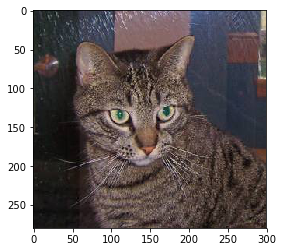

In [28]:
# Get eight examples of these augmented images
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]

# The original
plt.imshow(img[0])

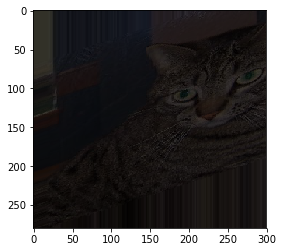

In [33]:
#an example of an augementated image
plt.imshow(aug_imgs[4])

# Note : Data Augementation is done on training set only and not on test set
#### Ex: adding data augementation

In [ ]:

from keras.preprocessing.image import ImageDataGenerator
#for training dataset
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True) 

#for test set
test_datagen = ImageDataGenerator(rescale=1./255)
#Thumbrule : copy from keras.io/preprocessing/image/

#For Training Data Set
training_set = train_datagen.flow_from_directory(
        'training_set',
        target_size=(64,64),
        batch_size=3,
        class_mode='binary')
#For Test Data Set
test_set = test_datagen.flow_from_directory(
        'test_set',
        target_size=(64,64),
        batch_size=3,
        class_mode='binary')
im, labe = next(training_set)

#steps per epoch = unique samples in training/batch_size
#validation steps = unique samples in test/batch_size
#epochs = no of iterations on the data
cnn.fit_generator(
        training_set,
        steps_per_epoch=6,
        epochs=25,
        validation_data=test_set,
        validation_steps=2)





### Here, I use Batch Normalization. 
Its easy to add, as shown below:

#### Attention: The usefulness of splitting the final model to 2 parts is shown below:
Splitting model increases flexibility on how model can be built.
i.e., Once convolutional model is pre computed, you can play and experiment with the second part of the model(i.e., Dense layer model)

Computing Convolution model takes time and resources. It is better to split the model and work.

In [ ]:
 dense_batch_norm_model = Sequential(
                             [
                                MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
                                Flatten(),
                                Dense(4096, activation='relu'),
                                BatchNormalization(),
                                Dropout(0.),
                                Dense(4096, activation='relu'),
                                BatchNormalization(),
                                Dropout(0.),
                                Dense(1, activation='sigmoid') #cats and dogs classification         
                             ]
                            )
    